# Image Augmentation - Eine Einführung

### Anforderungen:
Python 3.7
#### Packages:
- tensorflow
- tensorflow_datasets
- keras
- numpy
- pillow
- matplotlib

für Mac OS User eventuell erforderlich um die Graphen zu plotten:
- conda install nomkl

## Inhaltsverzeichnis
<ol>
    <li><a href="#einleitung">Einleitung</a></li>
    <li><a href="#augmentation_examples">Beispiele der Image Augmentation mit Tensorflow</a></li>
    <li><a href="#augmentation_mnist">Die Effektivität von Image Augmentation am Beispiel vom MNIST Datensatz</a></li>
    <li><a href="#schluss">Schlussteil</a></li>
    <li><a href="#quellen">Quellenverzeichnis</a></li>
</ol>


## Einleitung <div id="einleitung" />
Da wir Probleme mit dem Datensatz in unserem Projekt "Dogspiracy" hatten, haben wir uns überlegt das Thema Image Augmentation genauer zu betrachten. Der Hunderassen-Datensatz hat leider nicht den gewünschten Umfang, um erfolgreich Hunderassen klassifizieren zu können. Weil kein besserer Datensatz zur Verfügung steht und das Problem somit nicht mit dem Einsatz eines größeren Datensatzes gelöst werden kann, müssen andere Lösungen evaluiert werden. Durch Internetrecherche sind wir auf einen Artikel gestoßen, der uns darauf hingewiesen hat die Lernkurven genauer zu betrachten. Bei der Betrachtung ist uns aufgefallen, dass die Lernkurven auf Overfitting hindeuten.

Overfitting wird in dem Artikel wie folgt beschrieben:
"Overfitting refers to a model that has learned the training dataset too well, including the statistical noise or random fluctuations in the training dataset."
(dt. : "Overfitting bezieht sich auf ein Model, das den Trainingsdatensatz zu gut gelernt hat, einschließlich des statistischen Rauschens oder zufälliger Schwankungen im Trainingsdatensatz.")

Das Problem beim Overfitting liegt darin, dass je spezialisierter das Modell im Hinblick auf die Trainingsdaten ist, desto weniger gut kann es auf neue Daten generalisiert werden. Die Herausforderung dabei ist, dass nicht vorhergesagt werden kann, wie gut das Model performt, bis es mit einem neuen Datenset getestet wurde. Um dem entgegenzuwirken, kann beispielsweise der anfänglichen Datensatz in separate Trainings- und Testteilsätze aufgeteilt werden. Mit dieser Methode lässt sich annähernd abschätzen, wie gut das Model mit neuen Daten arbeiten wird. Wenn das Modell auf dem Trainingsdatensatz viel besser abschneidet als auf dem Testdatensatz, dann ist Overfitting wahrscheinlich. Eine 99%ige Accuracy beim Trainingsdatensatz und eine 50%ige Accuracy beim Testdatensatz kann dann deutlich auf Overfitting hinweisen.

Die folgende Abbildung zeigt wie Trainingsdaten (rote Kurve) und Testdaten (blaue Kurve) auseinander gehen.

![test](../assets/overfitting.jpeg)
_Abbildung 1: Beispielkurve für Overfitting aus dem Training für Hunderassenklassifizierung_

Auch Plots können hinsichtlich des Overfitting interpretiert werden. Ein Plot der Lernkurven zeigt Overfitting wenn:
- Der Plot des Trainings-Losses mit zunehmender Erfahrung weiter abnimmt.
- Der Plot des Validierungs-Losses bis zu einem Punkt abnimmt und dann wieder zu steigen beginnt.

![test](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2018/12/Example-of-Train-and-Validation-Learning-Curves-Showing-a-Training-Dataset-the-May-be-too-Small-Relative-to-the-Validation-Dataset.png)
_Abbildung 2: Beispielkurve für Overfitting aus dem Training für Hunderassenklassifizierung anhand des Losses. [Bildquelle](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2018/12/Example-of-Train-and-Validation-Learning-Curves-Showing-a-Training-Dataset-the-May-be-too-Small-Relative-to-the-Validation-Dataset.png)_

### Overfitting vermeiden¶

Es stehen einige Methoden zur Verfügung, um Overfitting zu eliminieren. Im nachfolgenden wird nur ein Auszug der vorhandenen Methoden genannt:

- Cross-Validation: Verwenden der anfänglichen Trainingsdaten, um mehrere mini train-test-splits zu generieren. Diese Splits können zum Tunen des Models verwendet werden.
- mehr Daten: Das Datenset ist zu klein und das Model benötigt mehr Daten.
- Image-Augmentation: Image Augmentation ist eine Methode mit der die Größe eines Trainingsdatensatzes künstlich erweitert werden kann, indem modifizierte Versionen von Bildern im Datensatz erstellt werden.

// TODO Alina
- Dropout
- Evtl. könnte es bei Ihnen auch mit Transfer Learning mit einem etablierten Netz, wie DenseNet funktionieren.
- he_normal-Initialisierung

Tensorflow bietet einige Möglichkeiten Image-Augmentation umzusetzten:

- Flipping
- Grayscaling
- Saturation
- Changing the brightness
- Rotation
- Center cropping

Im folgenden werden die einzelnen Möglichkeiten anhand eines Bildes aus dem Hunderassendatensatz demonstriert:

### Import der Bibliotheken

In [172]:
import urllib

import tensorflow as tf
# from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
AUTOTUNE = tf.data.experimental.AUTOTUNE

import tensorflow_datasets as tfds

from PIL import Image

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 5)

import numpy as np

## Beispiele der Image Augmentation mit Tensorflow <div id="augmentation_examples" />

Importieren einen Bildes:

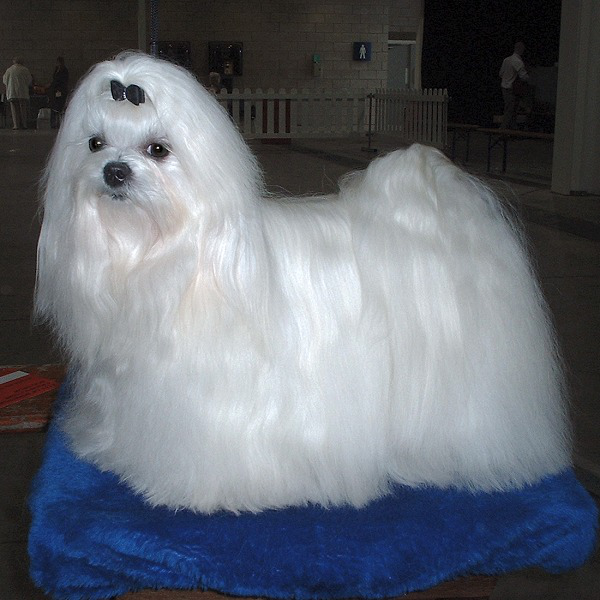

In [173]:
image_path = tf.keras.utils.get_file("good_boy.jpg", "https://raw.githubusercontent.com/MajusLenz/Dogspiracy-machine-learning/master/data/images/predict/good_boy.jpg")
Image.open(image_path)


Das Bild wird in Tensorflow Format konvertiert:

In [174]:
image_string=tf.io.read_file(image_path)
image=tf.image.decode_jpeg(image_string,channels=3)

Über die visualize Funktion kann das Originalbild mit dem augmentierten Bild verglichen werden:

In [175]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)


### Gängige Methoden zur Image Augmentation

In diesem Abschnitt werden die üblichsten Arten der Image Augmentation vorgeführt. Theoretisch gibt es natürlich noch sehr viele weitere Möglichkeiten. Die folgenden Methoden haben sich allerdings in der Praxis durchgesetzt.

Meistens ist es sinnvoll, die Augmentationen zufällig stark anzuwenden. In Tensorflow gibt es dazu spezielle Funktionen mit dem Prefix "random". Es werden in diesem Abschnitt also immer auch die passende Zufallsfunktion genannt.

Das Bild spiegeln:

Mit den beiden Funktionen ___flip_left_right___ und ___flip_up_down___ lassen sich Bilder horizontal oder vertikal spiegeln

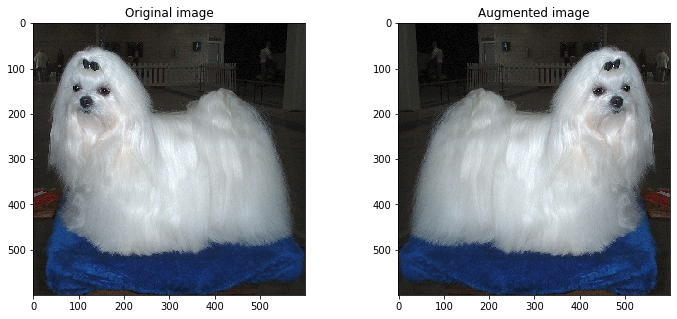

In [19]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

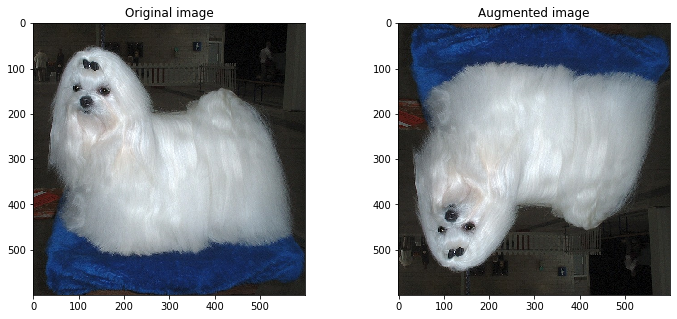

In [20]:
flipped = tf.image.flip_up_down(image)
visualize(image, flipped)

Farb-Sättigung:

Mittels ___adjust_saturation___ lässt sich die Sättigung verändern. Der ___saturation_factor___ ist dabei der Faktor, mit dem die Sättigung der Farben multipliziert wird. Bei ___saturation_factor___=1 geschieht demnach nichts, da 1 das neutrale Element der Multiplikation ist. Bei ___saturation_factor___=0 verliert das Bild vollständig seine Sättigung.

RGB-Bilder werden in den HSV-Farbraum (Farbwert H, Sättigung S, Dunkelstufe V) konvertiert und nach der Anpassung der Sättigung wieder auf RGB zurückgerechnet.

Mittels ___random_saturation___ wird der ___saturation_factor___ zwischen den grenzen, ___lower___ und ___upper___, pseudozufällig berechnet.

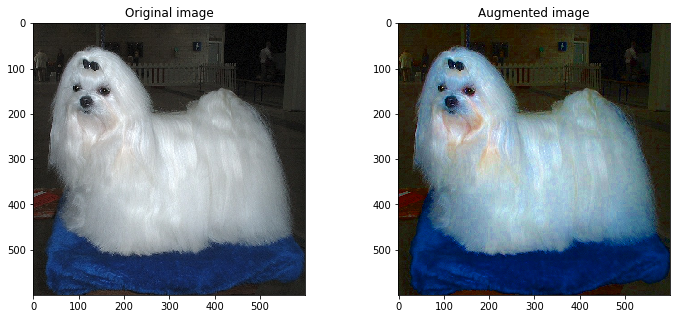

In [72]:
saturated = tf.image.adjust_saturation(image, saturation_factor=4)
visualize(image, saturated)


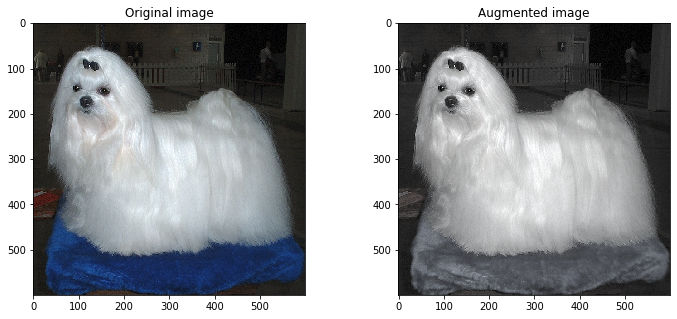

In [62]:
saturated = tf.image.random_saturation(image, lower=0.1, upper=1)
visualize(image, saturated)

Helligkeit:

Mittels ___adjust_brightness___ lässt sich die Helligkeit eines Bildes verändern. ___delta___ ist hierbei ein skalarer Wert, der auf den Helligkeitswert eines Pixels aufaddiert wird. Demnach liegen die möglichen Werte für ___delta___ zwischen -1 und 1. Bei ___delta___=0 wird das Bild nicht verändert. Bei ___delta___=-1 wird das Bild komplett schwarz. Bei ___delta___=1 wird das Bild komplett weiß. 

Durch ___random_brightness___ wird ___delta___ pseudozufällig berechnet. Der Parameter ___max_delta___ gibt dabei den möglichen Wertebereich der Zufallszahl an: [___-max_delta___, ___max_delta___ ]

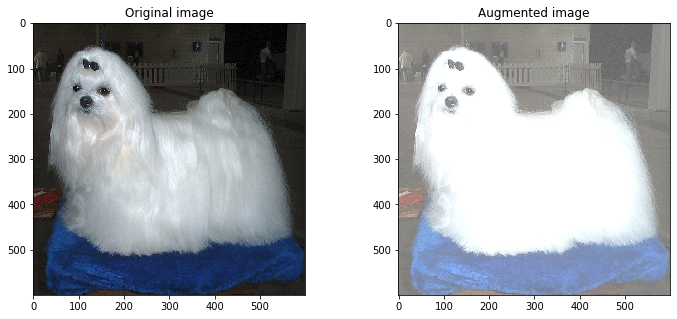

In [67]:
bright = tf.image.adjust_brightness(image, delta=0.4)
visualize(image, bright)

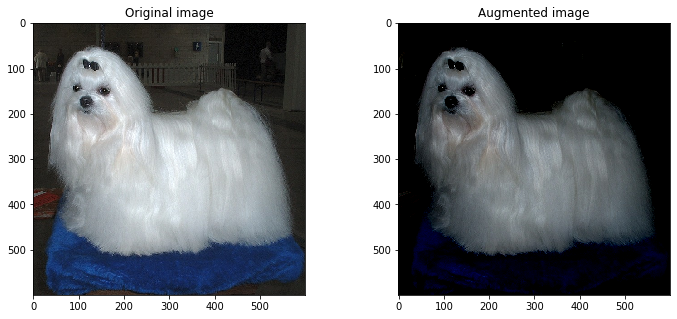

In [68]:
bright = tf.image.random_brightness(image, max_delta=0.8)
visualize(image, bright)

Kontrast:

Via ___adjust_contrast___ kann der Kontrast eines Bildes verändert werden. Der ___contrast_factor___ gibt hierbei den Faktor an, mit dem der Kontrast des Bildes multipliziert wird. Bei ___contrast_factor___=1 geschieht genau wie bei der Funktion ___adjust_saturation___ nichts. Bei __contrast_factor___=0 wird das Bild vollständig grau.

Mit Hilfe von ___random_contrast___ wird der ___contrast_factor___ zwischen den grenzen, ___lower___ und ___upper___, pseudozufällig berechnet.

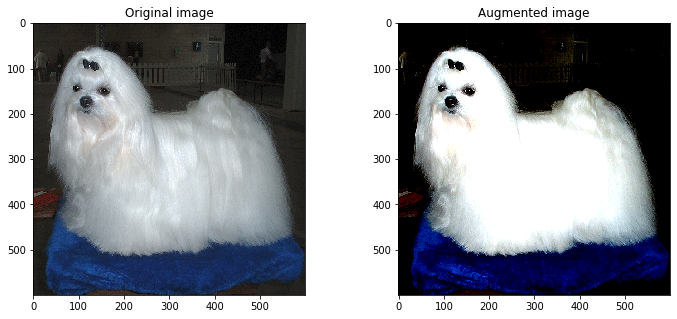

In [78]:
contrast = tf.image.adjust_contrast(image, 2)
visualize(image, contrast)

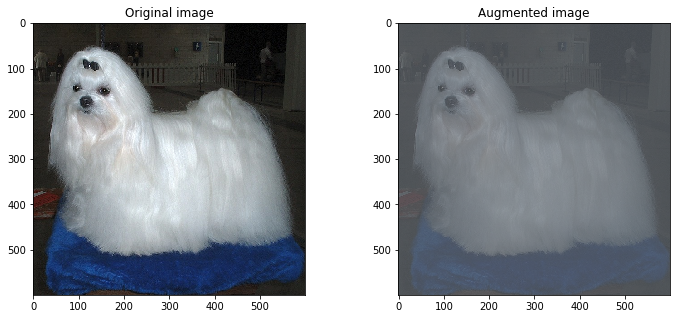

In [84]:
contrast = tf.image.random_contrast(image, lower=0.3, upper=0.8)
visualize(image, contrast)

Farbton:

Über ___adjust_hue___ lässt sich der Farbton eines Bildes anpassen.
Wenn man sich den HSV-Farbkreis vorstellt, dann kann mit ___adjust_hue___ der Farbton anhand dieses Kreises rotiert werden. 

___delta___ ist hierbei ein skalarer Wert, der den Rotationswinkel angibt. Der Rotationswinkel im Farbkreis berechnet sich dabei durch ___delta___ * 360°. Demnach liegen die möglichen Werte für ___delta___ zwischen -1 und 1. Bei ___delta___=0, ___delta___=-1 und ___delta___=1 wird das Bild nicht verändert, da logisch betrachtet immer um 0° rotiert wird. Bei ___delta___=0.5 wird die größte Farbveränderung erzielt. Der Farbton erreicht ist dann das gegenüberliegende Ende das Farbkreises. 

Durch ___random_hue___ wird ___delta___ pseudozufällig berechnet. Der Parameter ___max_delta___ gibt dabei den möglichen Wertebereich der Zufallszahl an: [___-max_delta___, ___max_delta___ ]

Der größtmögliche Wert für ___max_delta___ ist 0.5. Mit ___max_delta___=0.5 können alle Farben des Farbkreises erreicht werden.

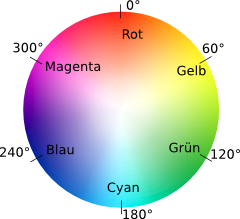

In [171]:
image_path = tf.keras.utils.get_file("hue-farbrad-mit-grad.png", "https://raw.githubusercontent.com/MajusLenz/Dogspiracy-machine-learning/master/assets/hue-farbrad-mit-grad.png")
Image.open(image_path)

Farbtonrad mit Gradzahlen - https://wisotop.de/hsv-und-hsl-farbmodell.php

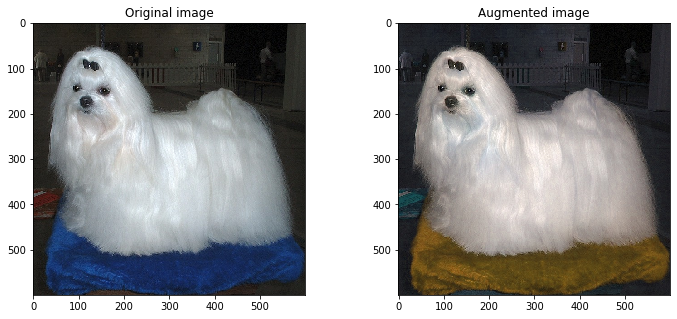

In [163]:
hue = tf.image.adjust_hue(image, 0.5)
visualize(image, hue)

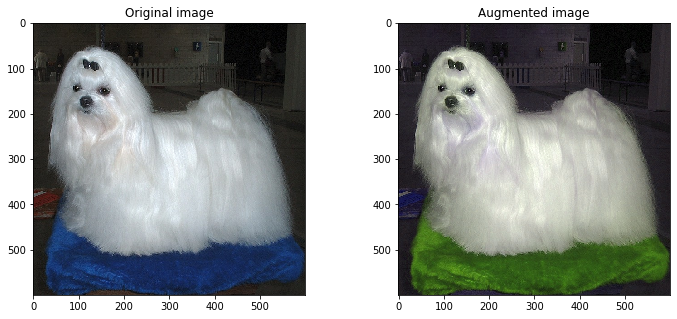

In [164]:
hue = tf.image.random_hue(image, 0.5)
visualize(image, hue)

Rotation:

Mit ___rot90___ lässt sich ein Bild um 90° gegen den Uhrzeigersinn drehen. ___k___ gibt dabei an, wie oft das Bild gedreht werden soll. Das heißt bei ___k___=3 wird das Bild um 270° gegen den Uhrzeigersinn gedreht, bzw. 90° im Uhrzeigersinn. Demnach findet gar keine Rotation statt für alle Werte ___k___ ∈ ℕ für die gilt: ___k___ _mod_ 4 = 0.

Eine Pseudozufallsmethode für ___rot90___ gibt es nicht von Tensorflow, diese kann aber wie folgt imporvisiert werden:
___rot90(image, k=randint(0, 3))___

Bilder können mit den eingebauten Methoden von Tensorflow nur in 90°-Schritten rotiert werden, da sonst Informationen an den Ecken des Bildes verloren gehen können, während die Ecken des Ergebnisbilds durch Füllinformationen aufgefüllt werden müssten. 

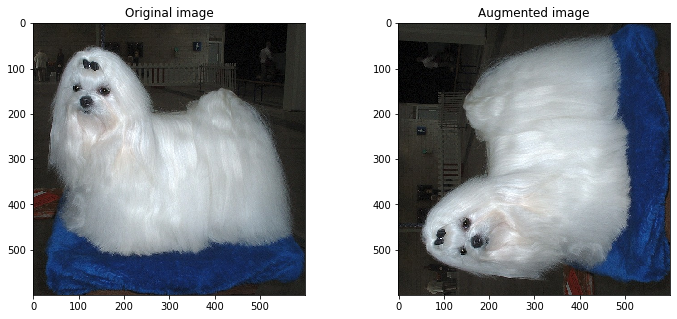

In [98]:
rotated = tf.image.rot90(image, k=1)
visualize(image, rotated)

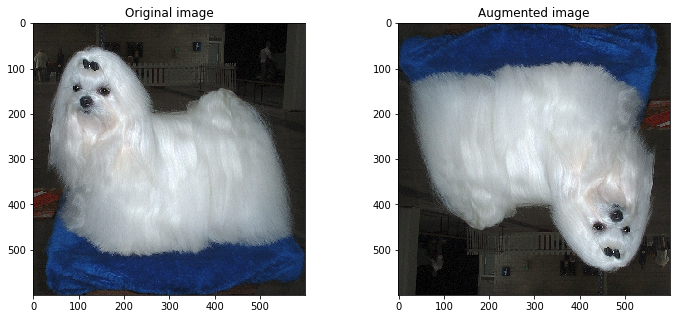

In [126]:
from random import randint

rotated = tf.image.rot90(image, k=randint(0, 3))
visualize(image, rotated)

Bildbeschneidung:

Die gängiste Beschneidungsmethode ist ___central_crop___, da die wichtigen Informationen eines Bildes in der Regel in der Bildmitte liegen. ___central_crop___ schneidet den äußeren Rand des Bildes ab. Der Parameter ___central_fraction___ gibt dabei die Intensität des Croppings an. Gültige Werte für ___central_fraction___ liegen zwischen 0 und 1, wobei die 0 ausgeschlossen ist. Bei ___central_fraction___=1 geschieht nichts. Bei ___central_fraction___=0.5 wird 50% des Bildes weggeschnitten.

Zu beachten ist, dass das Bild dadurch auch kleiner wird. Die Bildvergleich kann hier trügen, da beide Bilder gleich groß dargestellt werden. Ein Blick auf das Koordinatensystem verrät hier mehr.
Um ein Bild zu beschneiden und gleichzeitig die Größe zu ändern kann die Funktion ___crop_and_resize___ verwendet werden.

___central_crop___ hat keine pseudozufällige Variante. Aber auch hier lässt diese sich leicht improvisieren: ___central_crop(image, random())___

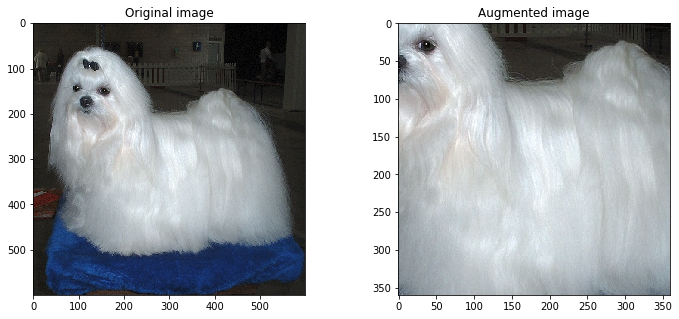

In [189]:
cropped = tf.image.central_crop(image, central_fraction=0.6)
visualize(image,cropped)


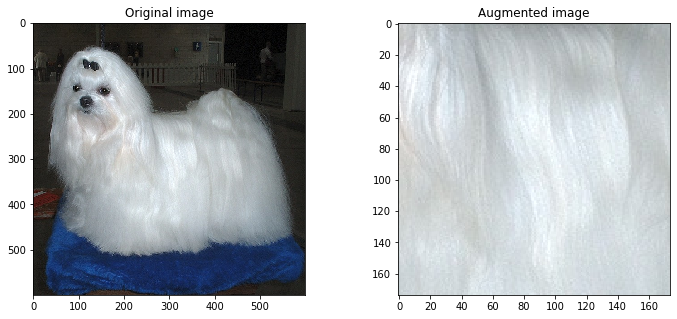

In [214]:
from random import random

cropped = tf.image.central_crop(image, central_fraction=random())
visualize(image,cropped)

Bildqualität:

Mit ___adjust_jpeg_quality___ kann sich die Kompressionsqualität des JPEG-Algorithmuses eines Bildes ändern. Der Wertebereich von ___jpeg_quality___ ist dabei von 0 bis 100.
Bei ___jpeg_quality___=1 verändert sich das Bild nicht. Die Qualität des Bildes kann so aber auch nicht künstlich verbessert werden, wenn das Originalbild schon schlecht unqualitativ komprimiert wurde.
Bei ___jpeg_quality___=0 wird die schlechtmöglichste JPEG-Kodierung angewendet.

Über ___random_jpeg_quality___ kann die JPEG-Qualität pseudozufällig angepasst werden. ___min_jpeg_quality___ und ___max_jpeg_quality___ geben dabei selbstredend die Grenzen des Wertebereichs der zufällig berechneten ___jpeg_quality___ an.

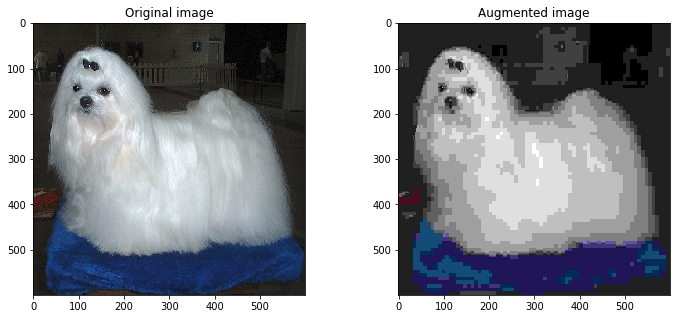

In [225]:
quality = tf.image.adjust_jpeg_quality(image, jpeg_quality=0)
visualize(image,quality)

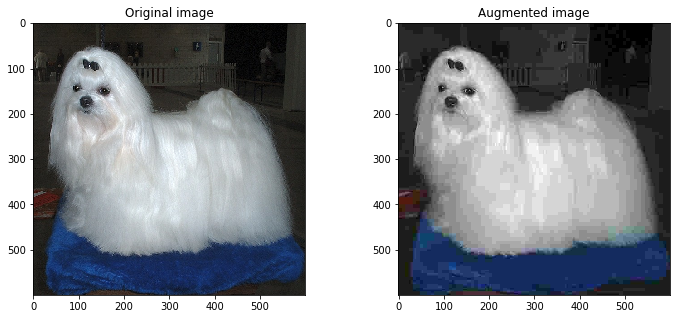

In [233]:
quality = tf.image.random_jpeg_quality(image, min_jpeg_quality=5, max_jpeg_quality=10)
visualize(image,quality)

## Die Effektivität von Image Augmentation am Beispiel vom MNIST Datensatz <div id="augmentation_mnist" />

In diesem Abschnitt wird der MNIST-Datensatz mit handgeschriebene Ziffern verwendet. MNIST enthält einen Trainingsdatensatz mit 60.000 Bildern und einen Testdatensatz mit 10.000 Bildern. Die Ziffern wurden größennormalisiert und in einem Bild mit fester Größe zentriert.

_"It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting."_ 

[MINST Webseite](http://yann.lecun.com/exdb/mnist/) 

Im Kontext des Jupyter Nodebooks wurde sich deshalb entschieden diesen Datensatz zu verwenden, um eine schnelle Ausführbarkeit und Experimentieren mit Parametern zu ermöglichen. Über das Package _tensorflow_datasets_ gibt es die Möglichkeit vorgefertigte Datensets herunterzuladen.

Im folgenden wird das Datenset geladen und die Form des Datensatzes ausgegeben:

In [89]:
dataset, info =  tfds.load('mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

num_train_examples= info.splits['train'].num_examples

print("Größe des Trainingsdatensatzes: "+ str(info.splits['train'].num_examples))
print("Größe des Testdatensatzes: "+ str(info.splits['test'].num_examples))
print(info.features['image'])
print(info.features['label'])

Größe des Trainingsdatensatzes: 60000
Größe des Testdatensatzes: 10000
Image(shape=(28, 28, 1), dtype=tf.uint8)
ClassLabel(shape=(), dtype=tf.int64, num_classes=10)


Aus den Ziffern 0 bis 9 ergeben sich 10 Klassen. Die Bilder haben die Form 28x28 Pixel und sind in Graustufen.

### Augmentierung

Da die Bilder des MNIST Datensatzen in Graustufen vorliegen, ergibt es keinen Sinn random_saturation zu nutzen. Außerdem sollte auch Spiegelung (flip_left_right) nicht eingesetzt werden, da das CNN sonst gespiegelte Zahlen lernt. 

In [90]:
def augment(image,label):
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  image = tf.image.resize_with_crop_or_pad(image, 34, 34) # Add 6 pixels of padding
  image = tf.image.random_crop(image, size=[28, 28, 1]) # Random crop back to 28x28
  image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
    
  return image,label

### Vorbereitung des Trainings 

Die Pixel der Bilder liegen in einem Wertebereich von 0 bis 255 (Graustufen). Über eine Hilfsmethode werden die Bilder zu Floatwerten konvertiert und in einen Wertebereich von [0,1] gebracht, also normalisiert. Um Overfitting zu erzeugen wird nur ein Subset des Datensets zum Trainieren verwendet.

In [91]:
def convert(image, label):
  image = tf.image.convert_image_dtype(image, tf.float32)
  return image, label

BATCH_SIZE = 64
NUM_SUBSET = 2048

augmented_train_batches = (
    train_dataset
    .take(NUM_SUBSET)
    .cache()
    .shuffle(num_train_examples//4)
    .map(augment, num_parallel_calls=AUTOTUNE) # mit Augmentation
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
) 

non_augmented_train_batches = (
    train_dataset
    .take(NUM_SUBSET)
    .cache()
    .shuffle(num_train_examples//4)
    .map(convert, num_parallel_calls=AUTOTUNE) # ohne Augmentation
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
) 

validation_batches = (
    test_dataset
    .map(convert, num_parallel_calls=AUTOTUNE)
    .batch(2*BATCH_SIZE)
)

### Model

Um Overfitting zu erzeugen und Image Augmentation als Maßnahme gegen Overfitting einzusetzen, wird ein Model ohne Convolutional (Conv2D) Layer mit nur zwei Schichten erzeugt. 
Um den Einfluss der Image Augmentation besser sichtbar zu machen, wurde das Model so rudimentär wie möglich gelassen und haben bewusst keine anderen Methoden zur Vermeidung von Overfitting genutzt, wie Dropout Layers oder Kernel Initializer.
Die letzte Dense Schicht gibt einen Tensor mit 10 Dimensionen aus (für jede Klasse eine Dimension).
Das Modell wird der Verlustfunktion SparseCategoricalCrossentropy kompiliert. Diese wird verwendet, wenn es mehr als zwei Klassen gibt und die Label in Form von Integern vorliegen. 



In [92]:
def new_model():
  model = tf.keras.Sequential([
      layers.Flatten(input_shape=(28, 28, 1)),
      layers.Dense(4096, activation='relu'),
      layers.Dense(4096, activation='relu'),
      layers.Dense(10)
  ])
  model.compile(optimizer = 'adam',
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

### Training im Vergleich

Es wird ein Training mit und ohne Image Augmentation durchgeführt und anschließend wird das Ergebnis als Graph geplottet.

In [22]:
NUMBER_OF_EPOCHS = 50

model_without_aug = new_model()

no_aug_history = model_without_aug.fit(non_augmented_train_batches, epochs=NUMBER_OF_EPOCHS, validation_data=validation_batches)

model_with_aug = new_model()

aug_history = model_with_aug.fit(augmented_train_batches, epochs=NUMBER_OF_EPOCHS, validation_data=validation_batches)

Epoch 1/50
32/32 [==============================] - 15s 469ms/step - loss: 0.9706 - accuracy: 0.7300 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/50
32/32 [==============================] - 14s 441ms/step - loss: 0.2302 - accuracy: 0.9321 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/50
32/32 [==============================] - 14s 440ms/step - loss: 0.1129 - accuracy: 0.9648 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 4/50
32/32 [==============================] - 14s 443ms/step - loss: 0.0795 - accuracy: 0.9766 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 5/50
32/32 [==============================] - 14s 440ms/step - loss: 0.0351 - accuracy: 0.9907 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 6/50
32/32 [==============================] - 14s 448ms/step - loss: 0.0246 - accuracy: 0.9927 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 7/50
32/32 [==============================] - 15s 469ms/step - loss: 0.0389 - accuracy: 

Um die Ergebnisse besser vergleichen zu können, werden Trainings- und Validierungsverläufe als Diagramm geplottet:

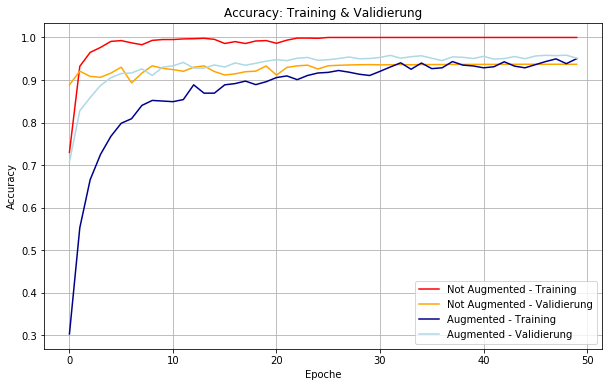

In [26]:
plt.figure(figsize = (10, 6))
plt.plot(range(NUMBER_OF_EPOCHS), no_aug_history.history["accuracy"], "red", label = "Not Augmented - Training")
plt.plot(range(NUMBER_OF_EPOCHS), no_aug_history.history["val_accuracy"], "orange", label = "Not Augmented - Validierung")
plt.plot(range(NUMBER_OF_EPOCHS), aug_history.history["accuracy"], "darkblue", label = "Augmented - Training")
plt.plot(range(NUMBER_OF_EPOCHS), aug_history.history["val_accuracy"], "lightblue", label = "Augmented - Validierung")
plt.title("Accuracy: Training & Validierung")
plt.ylabel("Accuracy")
plt.xlabel("Epoche")
plt.legend()
plt.grid()
plt.show()

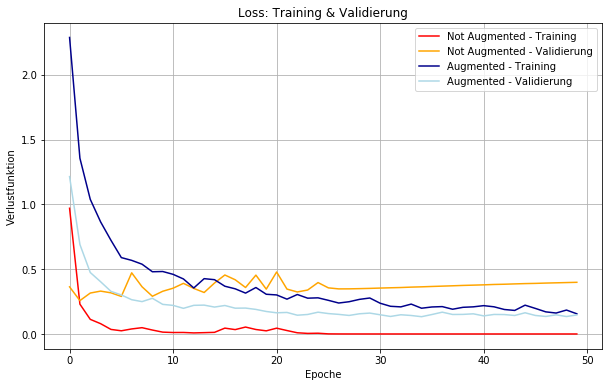

In [25]:
plt.figure(figsize = (10, 6))
plt.plot(range(NUMBER_OF_EPOCHS), no_aug_history.history["loss"], "red", label = "Not Augmented - Training")
plt.plot(range(NUMBER_OF_EPOCHS), no_aug_history.history["val_loss"], "orange", label = "Not Augmented - Validierung")
plt.plot(range(NUMBER_OF_EPOCHS), aug_history.history["loss"], "darkblue", label = "Augmented - Training")
plt.plot(range(NUMBER_OF_EPOCHS), aug_history.history["val_loss"], "lightblue", label = "Augmented - Validierung")
plt.title("Loss: Training & Validierung")
plt.ylabel("Verlustfunktion")
plt.xlabel("Epoche")
plt.legend()
plt.grid()
plt.show()

## Schlussteil <div id="schluss" />

Bei einem Training mit 50 Epochen konvergiert die Trainingskurve des Models **ohne Image Augmentation** gegen eine Accuracy von etwa 100%, während die Validierungskurve bei etwa 93% konvergiert. Dies ist ein Unterschied von 7% in der Accuracy.

Der Loss des Models ohne Image Augmentation geht zwischen Traing und Validierung liegt noch weiter auseinander. Während die Trainingskurve gegen 0 konvergiert, liegt der Loss der Validierungskurve bei etwa 0,4 und nähert sich im Trend 0,5 an. 
Wie im ersten Teil dieser Arbeit beschrieben, ist Overfitting am Plott zu erkennen, wenn der Plot des Trainings-Losses mit zunehmender Erfahrung weiter abnimmt, der Plot des Validierungs-Losses jedoch bis zu einem Punkt abnimmt und dann wieder zu steigen beginnt.

Die Trainingskurve des Models **mit Image Augmentation** konvergiert die Accurcy




Image Augmentierung kann zwar als Instrument eingesetzt werden, um einem zu kleinen Datensatzt gegenzusteuern, allerdings 

## Quellenverzeichnis <div id="quellen" />
- https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/
- https://www.tensorflow.org/tutorials/images/data_augmentation
- https://www.tensorflow.org/datasets/overview
- http://yann.lecun.com/exdb/mnist/